In [1]:
import pandas as pd
import numpy as np
import os
import re

def extract_numeric_features(data):
    feature_columns = ['充放电次数', '使用时长', '当前电量']
    numeric_data = pd.DataFrame()

    for col in feature_columns:
        if col in data.columns:
            extracted_values = []
            for value in data[col]:
                if pd.isna(value):
                    extracted_values.append(np.nan)
                else:
                    matches = re.findall(r'\d+\.?\d*', str(value))
                    if matches:
                        try:
                            extracted_values.append(float(matches[0]))
                        except ValueError:
                            extracted_values.append(np.nan)
                    else:
                        extracted_values.append(np.nan)
            numeric_data[col] = extracted_values
    return numeric_data

def normalize_features(data, method='min_max'):
    normalized_data = data.copy()
    
    if method == 'min_max':
        for col in data.columns:
            min_val = data[col].min()
            max_val = data[col].max()
            if max_val != min_val:
                normalized_data[col] = (data[col] - min_val) / (max_val - min_val)
            else:
                normalized_data[col] = 0
    elif method == 'z_score':
        for col in data.columns:
            mean_val = data[col].mean()
            std_val = data[col].std()
            if std_val != 0:
                normalized_data[col] = (data[col] - mean_val) / std_val
            else:
                normalized_data[col] = 0
    
    return normalized_data

def load_battery_data(file_path, test_ratio=0.2, random_state=None, normalize=True, normalize_method='min_max'):

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Excel文件 {file_path} 不存在")

    try:
        data = pd.read_excel(file_path)
    except Exception as e:
        raise ValueError(f"读取Excel文件失败: {str(e)}")

    numeric_features = extract_numeric_features(data)

    if normalize:
        numeric_features = normalize_features(numeric_features, method=normalize_method)

    label_column = '电池量'
    y = data[label_column].values

    X = numeric_features.values
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test



In [2]:
from collections import OrderedDict

class Affine:
    def __init__(self,W,b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self,x):
        self.x = x
        out = np.dot(x,self.W) + self.b
        return out
    
    def backward(self,dout):
        dx = np.dot(dout,self.W.T)
        self.dW = np.dot(self.x.T,dout)
        self.db = np.sum(dout,axis=0)
        return dx
    
class AddPower:
    def __init__(self,exponent):
        self.exponent = exponent
        self.x = None
        self.dExponent = None
    
    def forward(self,x):
        x += 1e-7
        self.x = x
        out = np.power(x,self.exponent)
        return out
    
    def backward(self,dout):
        dx = np.power(self.x,self.exponent-1) * self.exponent * dout
        self.dExponent = self.x ** self.exponent * np.log(self.x) * dout
        self.dExponent = np.mean(dx,axis=0)
        return dx

def mse(y,t):
    return np.mean((y-t)**2) * 0.5

class MSE:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    def forward(self,y,t):
        self.y = y
        self.t = t
        self.loss = mse(y,t)
        return self.loss
    
    def backward(self,dout=1):
        batch_size = self.t.shape[0]
        if len(self.t.shape) == 1:
            t_reshaped = self.t.reshape(-1, 1)
        else:
            t_reshaped = self.t
        dx = (self.y - t_reshaped) / batch_size
        return dx

class battery_model:
    def __init__(self,input_size=3,output_size=1,weight_init=0.1):
        self.params = {}
        self.params['exponent'] = np.ones(input_size)
        self.params['W1'] = np.random.randn(input_size,output_size) * weight_init
        self.params['b1'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['AddPower'] = AddPower(self.params['exponent'])
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        
        self.loss_layer = MSE()
        
        
    def predict(self,x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self,x,t):
        y = self.predict(x)
        if len(t.shape) == 1:
            t = t.reshape(-1, 1)
        return self.loss_layer.forward(y,t)
    
    def gradient(self,x,t):
        if len(t.shape) == 1:
            t = t.reshape(-1, 1)
        self.loss(x,t)
        dout = self.loss_layer.backward()
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        gradient = {
                'exponent': self.layers['AddPower'].dExponent,
                'W1': self.layers['Affine1'].dW,
                'b1': self.layers['Affine1'].db
        }
        
        return gradient
    
    def accuracy(self,x,t,threshold=0.02):
        y = self.predict(x)
        
        if len(t.shape) == 1:
            t = t.reshape(-1, 1)

        relative_error = np.abs((y - t) / (t + 1e-7))

        correct = relative_error <= threshold
        return np.mean(correct)

In [3]:
class Adam:
    def __init__(self,lr=0.1,beta1=0.9,beta2=0.99):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.v =  None
        self.h = None
        
    def update(self,params,grads):
        if self.v is None:
            self.v = {}
            for key,val in params.items():
                self.v[key] = np.zeros_like(val)
        if self.h is None:
            self.h = {}
            for key,val in params.items():
                self.h[key] = np.zeros_like(val)
        self.iter += 1
        for key in params.keys():
            self.v[key] = self.beta1 * self.v[key] + (1 - self.beta1) * grads[key]
            self.h[key] = self.beta2 * self.h[key] + (1 - self.beta2) * grads[key] * grads[key]
            v_correct = self.v[key] / max(1 - np.power(self.beta1, self.iter), 1e-7)
            h_correct = self.h[key] / max(1 - np.power(self.beta2, self.iter), 1e-7)
            params[key] -= self.lr * v_correct / (np.sqrt(h_correct) + 1e-7) 

In [4]:
def batch_train(model, X_train, y_train, X_test=None, y_test=None, epochs=10, batch_size=100, learning_rate=0.1, verbose=True, optimizer=Adam):

    num_samples = X_train.shape[0]
    num_batches = num_samples // batch_size
    optimizer = optimizer(learning_rate)
    
    if num_samples % batch_size != 0:
        num_batches += 1
        
    history = {
        'train_loss': [],
        'test_loss': [],
        'train_accuracy': [],
        'test_accuracy': []
    }
    
    for epoch in range(epochs):
        indices = np.random.permutation(num_samples)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]
        
        epoch_loss = 0
        
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
            
            X_batch = X_train_shuffled[start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]
            
            grads = model.gradient(X_batch, y_batch)

            optimizer.update(model.params, grads)

            
            batch_loss = model.loss(X_batch, y_batch)
            epoch_loss += batch_loss
            
        avg_loss = epoch_loss / num_batches
        history['train_loss'].append(avg_loss)
        
        train_acc = model.accuracy(X_train, y_train)
        history['train_accuracy'].append(train_acc)
        
        if X_test is not None and y_test is not None:
            test_loss = model.loss(X_test, y_test)
            test_acc = model.accuracy(X_test, y_test)
            history['test_loss'].append(test_loss)
            history['test_accuracy'].append(test_acc)
            
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Test Loss: {test_loss:.4f} - Train Acc: {train_acc:.4f} - Test Acc: {test_acc:.4f}")
        else:
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Train Acc: {train_acc:.4f}")
                
    return history


In [5]:
X_train, X_test, y_train, y_test = load_battery_data('./TestDataCollection/BatteryData.xlsx')

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(800, 3) (200, 3) (800,) (200,)


In [6]:
model = battery_model()

history = batch_train(model, X_train, y_train, X_test, y_test,epochs=500, batch_size=100, learning_rate=0.01)

Epoch 10/500 - Loss: 0.0079 - Test Loss: 0.0086 - Train Acc: 0.1075 - Test Acc: 0.0900
Epoch 20/500 - Loss: 0.0055 - Test Loss: 0.0061 - Train Acc: 0.1388 - Test Acc: 0.1450
Epoch 30/500 - Loss: 0.0043 - Test Loss: 0.0048 - Train Acc: 0.1525 - Test Acc: 0.1050
Epoch 40/500 - Loss: 0.0030 - Test Loss: 0.0033 - Train Acc: 0.1800 - Test Acc: 0.1400
Epoch 50/500 - Loss: 0.0018 - Test Loss: 0.0019 - Train Acc: 0.2075 - Test Acc: 0.1750
Epoch 60/500 - Loss: 0.0008 - Test Loss: 0.0009 - Train Acc: 0.3063 - Test Acc: 0.2800
Epoch 70/500 - Loss: 0.0003 - Test Loss: 0.0003 - Train Acc: 0.5525 - Test Acc: 0.5350
Epoch 80/500 - Loss: 0.0001 - Test Loss: 0.0001 - Train Acc: 0.8063 - Test Acc: 0.7950
Epoch 90/500 - Loss: 0.0001 - Test Loss: 0.0001 - Train Acc: 0.9337 - Test Acc: 0.9350
Epoch 100/500 - Loss: 0.0001 - Test Loss: 0.0001 - Train Acc: 0.9663 - Test Acc: 0.9550
Epoch 110/500 - Loss: 0.0001 - Test Loss: 0.0001 - Train Acc: 0.9400 - Test Acc: 0.9400
Epoch 120/500 - Loss: 0.0001 - Test Loss:

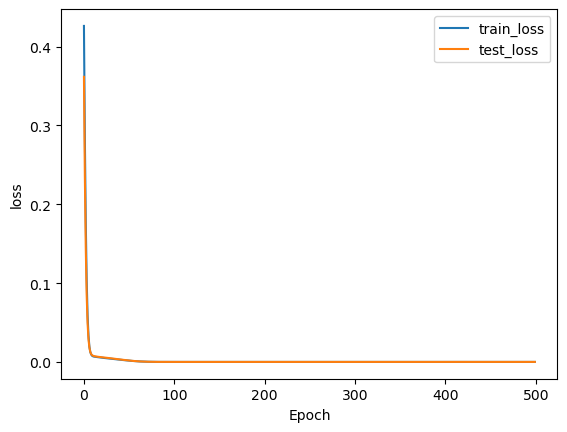

In [7]:
import matplotlib.pyplot as plt
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['test_loss'], label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

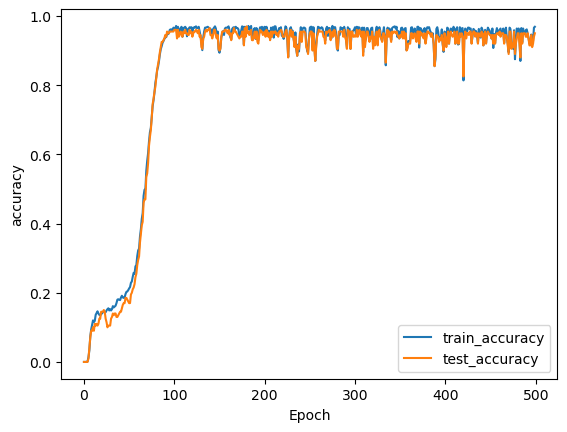

In [8]:
plt.plot(history['train_accuracy'], label='train_accuracy')
plt.plot(history['test_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [9]:
print(history['train_accuracy'][-1])
print(history['test_accuracy'][-1])
print(model.params)

0.96875
0.95
{'exponent': array([0.83901595, 0.46648104, 0.86171178]), 'W1': array([[-0.02123186],
       [ 0.01521085],
       [ 0.00840958]]), 'b1': array([0.97953333])}


In [10]:
print(X_train[13])
print(model.predict(X_train[13].reshape(1, -1)))

[0.59095909 0.52169656 0.31116111]
[[0.98018143]]
